In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler
from scipy.stats import rankdata

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
#### Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home12/khou/scTRS_results/'

# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs', flag_scale=False, flag_filter_genes=True)
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))


Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22953
# time=14.6s


In [3]:
# precompute some statistics
adata = data_facs_ct.copy()
mean, var = util.get_sparse_var(adata.X, axis=0)
adata.var['mean'] = mean
adata.var['var'] = var
adata.var['mean_rank'] = rankdata(adata.var['mean'], method='ordinal') - 1

mean, var = util.get_sparse_var(adata.X, axis=1)
adata.obs['mean'] = mean
adata.obs['var'] = var

In [4]:
# Genearate null gene sets
np.random.seed(0)
dic_trait_geneset = {}
n_gene = 500

df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.X.mean(axis=0).T
df_gene = df_gene.sort_values(by=['mean'])


ind_select = np.random.permutation(2000)[:n_gene]
gene_list =  list(df_gene.index[-2000:][ind_select])

trait_X = adata[:, gene_list].X.toarray()
trait_trs = trait_X.mean(axis=1)

In [5]:
import numpy as np
from scipy import stats
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.generalized_linear_model import families
from statsmodels.regression.linear_model import OLS
from patsy import build_design_matrices, dmatrix

def poisson_deviance(fitted, y, df):

    l = np.log(fitted)
    Fl = fitted.cumsum()
    Fr = fitted[::-1].cumsum()
    dev = ((y - fitted) / np.sqrt((fitted + 1)))
    dev = sum(np.power(dev[1:(len(y)-1)], 2)) / (len(y) - 2 - df)
    return dev

# https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.local_fdr.html
class ExpPolyDensity():
    """
    Fit exponential of polynomial function for density estimation
    """
    def __init__(self, nbins = 120, df = 7, design_type = 'poly'):
        self.nbins = nbins
        self.df = df
        assert design_type in ['poly', 'ns']
        self.design_type = design_type
    
    def design_fit_transform(self, x):
        if self.design_type == 'poly':
            # TODO: implement this with pasty for uniformality
            
            # The design matrix at bin centers
            dmat = np.vander(x, self.df + 1)
            
            # Rescale the design matrix
            self.design_sd = dmat.std(0)
            self.design_ii = self.design_sd > 1e-8
            dmat[:, self.design_ii] /= self.design_sd[self.design_ii]
        
        elif self.design_type == 'ns':
            # natural spline fit
            
            dmat = dmatrix(f"cr(x, df={self.df})", {"x": x})
            self.design_info = dmat.design_info
            
        return dmat
        
        
    def design_transform(self, x):
        if self.design_type == 'poly':
            dmat = np.vander(x, self.df + 1)
            dmat[:, self.design_ii] /= self.design_sd[self.design_ii]
        
        elif self.design_type == 'ns':
            dmat = build_design_matrices([self.design_info], {"x": x})[0]

        return dmat
    
    def fit(self, zscores):
        # Bins for Poisson modeling of the marginal Z-score density
        minz = min(zscores)
        maxz = max(zscores)
        bins = np.linspace(minz, maxz, self.nbins)
        self.normalize_const = 1 / ((bins[1] - bins[0]) * len(zscores))

        # Bin counts
        zhist = np.histogram(zscores, bins)[0]

        # Bin centers
        zbins = (bins[:-1] + bins[1:]) / 2

        # The design matrix at bin centers
        dmat = self.design_fit_transform(zbins)
        
        start = OLS(np.log(1 + zhist), dmat).fit().params

        # Poisson regression
        self.model = GLM(zhist, dmat, family=families.Poisson()).fit(start_params=start)
        deviance = poisson_deviance(self.model.fittedvalues, zhist, self.df)
        if deviance > 1.5:
            warnings.warn("f(z) misfit = " + str(round(deviance, 1)) + ". Rerun with larger df.")
        return self
            
    def score_samples(self, zscores):
        dmat_full = self.design_transform(zscores)
        fz = self.model.predict(dmat_full) * self.normalize_const
        
        return fz

In [6]:
p0 = 0.9
left, right = ((1 - p0) / 2, 1 - (1 - p0) / 2)
left_bound, right_bound = np.quantile(trait_trs, [left, right])

null_index = (left_bound <= trait_trs) & (trait_trs <= right_bound)
null_density = ExpPolyDensity(df=10, design_type='ns').fit(trait_trs[null_index])
mix_density = ExpPolyDensity(df=10, design_type='ns').fit(trait_trs)

/opt/conda/root/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: f(z) misfit = 1.5. Rerun with larger df.


<Figure size 1008x576 with 0 Axes>

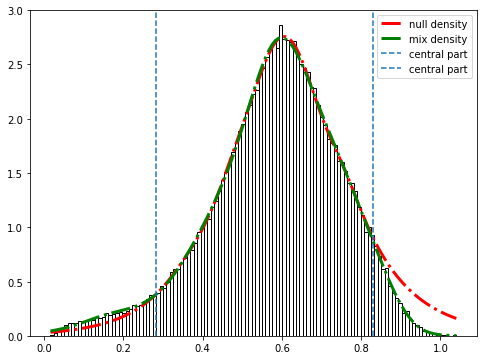

In [7]:
fig = plt.figure(figsize = (14, 8))
num_breaks = 120
bins = np.linspace(min(trait_trs), max(trait_trs), num_breaks)
plt.figure(figsize=(8, 6))
plt.hist(trait_trs, bins = bins, fill=False, density=True)
plt.plot(bins, null_density.score_samples(bins) * p0, color='r', ls='-.', linewidth = 3, label='null density')
plt.plot(bins, mix_density.score_samples(bins), color='g', ls = '-.', linewidth = 3, label='mix density')

plt.axvline(x=left_bound, ls='--', label='central part')
plt.axvline(x=right_bound, ls='--', label='central part')
plt.legend()
plt.show()

# For some artificial data

In [8]:
np.random.seed(1)
data = np.concatenate([
    np.random.normal(loc=0, size=10000),
    np.random.normal(loc=3, scale=2, size=1000)])

In [9]:
p0 = 0.9
left, right = ((1 - p0) / 2, 1 - (1 - p0) / 2)
left_bound, right_bound = np.quantile(data, [left, right])

null_index = (left_bound <= data) & (data <= right_bound)
null_density = ExpPolyDensity(df=5, design_type='ns').fit(data[null_index])
mix_density = ExpPolyDensity(df=10, design_type='ns').fit(data)

<Figure size 1008x576 with 0 Axes>

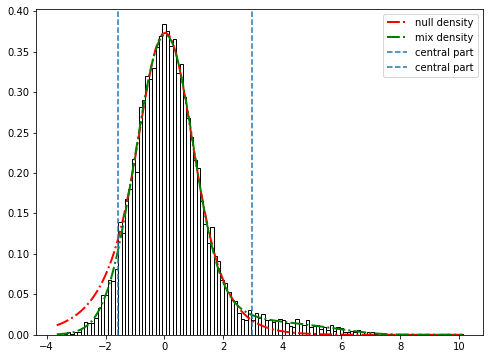

In [10]:
fig = plt.figure(figsize = (14, 8))
num_breaks = 120
bins = np.linspace(min(data), max(data), num_breaks)
plt.figure(figsize=(8, 6))
plt.hist(data, bins = bins, fill=False, density=True)
plt.plot(bins, null_density.score_samples(bins) * p0, color='r', ls='-.', linewidth = 2, label='null density')
plt.plot(bins, mix_density.score_samples(bins), color='g', ls = '-.', linewidth = 2, label='mix density')

plt.axvline(x=left_bound, ls='--', label='central part')
plt.axvline(x=right_bound, ls='--', label='central part')
plt.legend()
plt.show()